In [1]:
%matplotlib inline
from decimal import Decimal
import itertools
from pprint import pprint
import math

import pandas
import seaborn
from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
import numpy

import metrics
import simulate
import harvesting
import market
import plot
import mortality
from plot import plt
import withdrawal
from portfolio import Portfolio
import montecarlo

In [2]:
series = market.Returns_US_1871()
START_YEAR=1871

#series = market.Japan_1957()
#START_YEAR=1957

In [3]:
def withdrawals(series,
                strategy_pair,
                portfolio=(600000, 400000),
                years=40):
    withdraw, harvesting = strategy_pair
    portfolio = Portfolio(portfolio[0], portfolio[1])
    strategy = harvesting(portfolio).harvest()
    strategy.send(None)
    withdrawal_strategy = withdraw(portfolio, strategy).withdrawals()
    annual = []

    # Withdrawals happen at the start of the year, so the first time
    # we don't have any performance data to send them....
    data = withdrawal_strategy.send(None)
    annual.append(data)
    years -= 1

    for _, d in zip(range(years), series):
        data = withdrawal_strategy.send(d)
        annual.append(data)
    return annual


In [4]:
def test_withdrawal_strategies(year, strategies_to_test, years=25):
    results = {}
    for strategy in strategies_to_test:
        starting_portfolio = (600000,400000)

        x = withdrawals(series.iter_from(year),
                                 years=years,
                                 strategy_pair=strategy,
                                 portfolio=starting_portfolio)
        name = strategy[0].__name__
        results[name] = x
    return results

In [5]:
def semideviation(frame, goal=40000):
    values = frame[lambda s: s < goal]
    if len(values) > 0:
        sumvalues = sum(((goal - v) ** 2 for v in values))
        average = sumvalues / len(values)
        return math.sqrt(average)
    else:
        return 0

In [6]:
def median_cut(frame, goal=40000):
    values = frame[lambda s: s < goal]
    if len(values) > 0:
        return values.apply(lambda s: s - goal).median()
    else:
        return 0

In [7]:
lens = lambda x: float(x.withdraw_r)

In [8]:
strategies_to_test = [
    (withdrawal.VPW, harvesting.N_60_RebalanceHarvesting),
    (withdrawal.VPWBank, harvesting.N_60_RebalanceHarvesting),
]

data = {
    'VPW' : [],
    'VPWBank' : []
}

In [9]:
%pdb on

for year in range(START_YEAR, 1985):
    results = test_withdrawal_strategies(year, strategies_to_test, years=30)
    for strategy in results.keys():
        ws = [lens(n) for n in results[strategy]]
        data[strategy] = data[strategy] + ws

for strategy, values in data.items():
    s = pandas.Series(values)
    print('Semideviation', strategy, semideviation(s))
    
for strategy, values in data.items():
    s = pandas.Series(values)
    print('Stdev', strategy, s.std())
    
for strategy, values in data.items():
    s = pandas.Series(values)
    print('Median Cut', strategy, median_cut(s))

Automatic pdb calling has been turned ON
Semideviation VPWBank 8030.206700479058
Semideviation VPW 7970.508121992509
Stdev VPWBank 5636.393497840362
Stdev VPW 24330.68847259992
Median Cut VPWBank -6375.114814480476
Median Cut VPW -6471.180415975759


In [10]:
num_vpw_cuts = 0
num_bank_cuts = 0
for year in range(START_YEAR, 1985):
    results = test_withdrawal_strategies(year, strategies_to_test, years=30)
    
    vpw_real_wd = pandas.Series([lens(n) for n in results['VPW']])
    bank_real_wd = pandas.Series([lens(n) for n in results['VPWBank']])
    vpw_cuts = len(vpw_real_wd[lambda s: s < 49000])
    bank_cuts = len(bank_real_wd[lambda s: s < 49000])
    if vpw_cuts != bank_cuts:
#    if vpw_cuts or bank_cuts:
        print(year, ':', 'VPW', vpw_cuts, 'Bank', bank_cuts)
        
    num_vpw_cuts += vpw_cuts
    num_bank_cuts += bank_cuts
            
print('Num VPW Cuts', num_vpw_cuts)
print('Num Bank Cuts', num_bank_cuts)

1889 : VPW 2 Bank 1
1890 : VPW 5 Bank 3
1891 : VPW 3 Bank 0
1892 : VPW 8 Bank 6
1893 : VPW 5 Bank 0
1894 : VPW 6 Bank 2
1895 : VPW 9 Bank 6
1896 : VPW 8 Bank 4
1897 : VPW 11 Bank 7
1898 : VPW 16 Bank 12
1899 : VPW 25 Bank 24
1900 : VPW 12 Bank 7
1901 : VPW 18 Bank 15
1903 : VPW 16 Bank 15
1904 : VPW 14 Bank 9
1905 : VPW 18 Bank 17
1906 : VPW 25 Bank 24
1908 : VPW 11 Bank 9
1910 : VPW 16 Bank 15
1913 : VPW 15 Bank 14
1914 : VPW 13 Bank 12
1916 : VPW 13 Bank 12
1917 : VPW 10 Bank 9
1927 : VPW 1 Bank 0
1928 : VPW 8 Bank 2
1930 : VPW 17 Bank 12
1931 : VPW 11 Bank 7
1933 : VPW 2 Bank 0
1934 : VPW 12 Bank 9
1935 : VPW 6 Bank 3
1936 : VPW 16 Bank 15
1946 : VPW 9 Bank 8
1951 : VPW 1 Bank 0
1952 : VPW 3 Bank 0
1953 : VPW 6 Bank 1
1954 : VPW 5 Bank 0
1955 : VPW 11 Bank 0
1956 : VPW 14 Bank 13
1957 : VPW 14 Bank 11
1958 : VPW 12 Bank 2
1959 : VPW 17 Bank 14
1960 : VPW 18 Bank 14
1961 : VPW 18 Bank 16
1962 : VPW 23 Bank 22
1963 : VPW 20 Bank 19
1975 : VPW 1 Bank 0
Num VPW Cuts 989
Num Bank Cuts 85

In [11]:
def compare_year(year, lens, title):
    results = test_withdrawal_strategies(year, strategies_to_test, years=30)
    
    fig, ax = plt.subplots()

    if '%' not in title:
        plot.format_axis_labels_with_commas(ax.get_yaxis())

    plt.xlabel('Year of Retirement')
    plt.title('Retirement in Year %s (%s)' % (year, title))

    for strategy in (sorted(results.keys())):
        ax_n = fig.add_subplot(111, sharex=ax, sharey=ax)
        ws = [lens(n) for n in results[strategy]]
        ax_n.plot(ws, label=strategy)
        ax_n.set_ymargin(0.05)
    plt.legend(loc=0)
    ax.set_ylim(bottom=0)
    plt.show()

In [12]:
def chart_all(year):
#    compare_year(year, lambda x: x.portfolio_stocks/x.portfolio_n*100, "Stock %")
#    compare_year(year, lambda x: x.portfolio_n, "Portfolio (Nominal)")
#    compare_year(year, lambda x: x.portfolio_r, "Portfolio (Real)")
#    compare_year(year, lambda x: x.withdraw_n, "Withdrawals (Nominal)")
    compare_year(year, lambda x: x.withdraw_r, "Withdrawals (Real)")

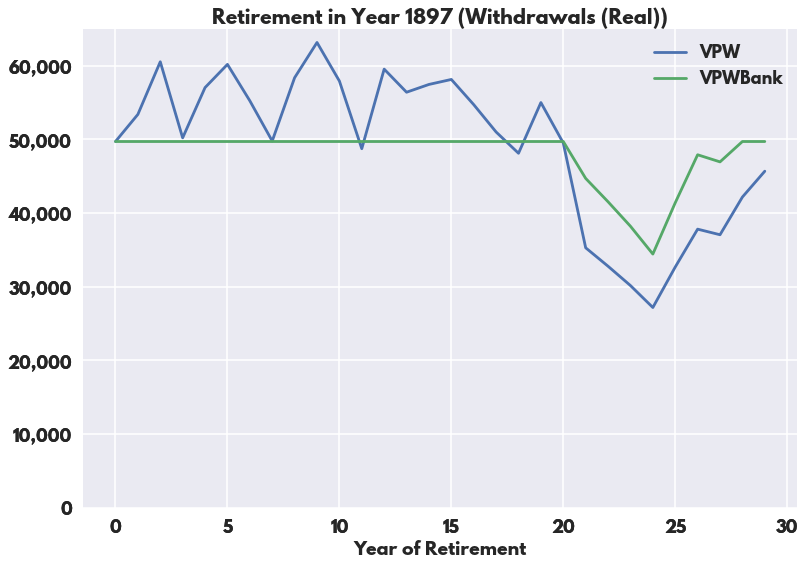

In [13]:
chart_all(1897)